<a href="https://colab.research.google.com/github/akshithadev19/projects_lab_submissions/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-06 19:13:51--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.49MB/s    in 0.6s    

2025-02-06 19:13:52 (1.49 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


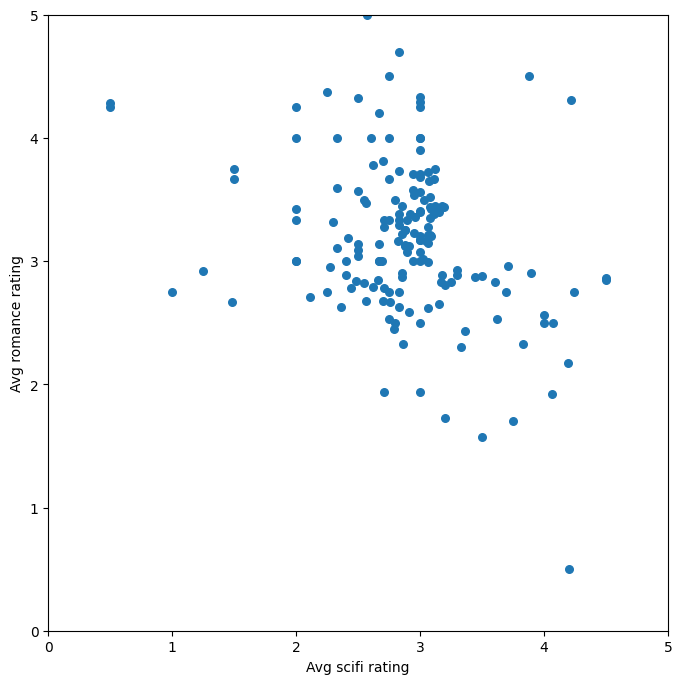

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

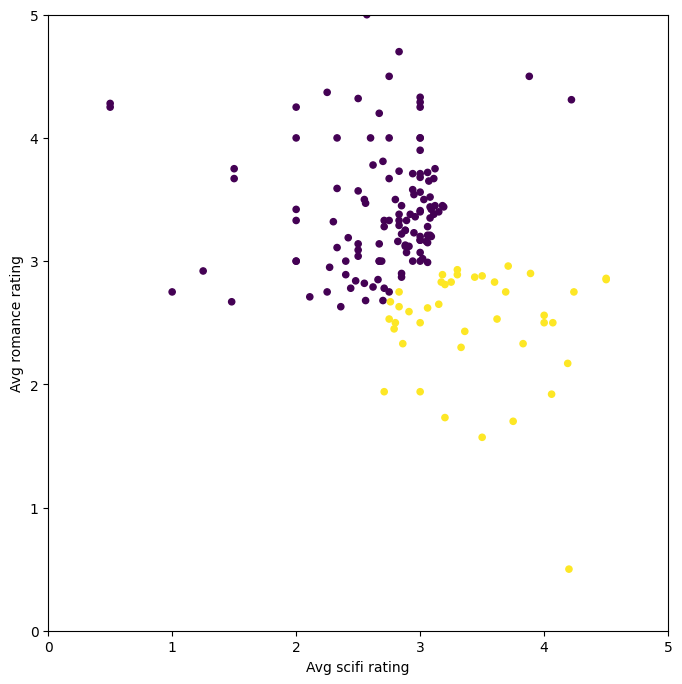

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

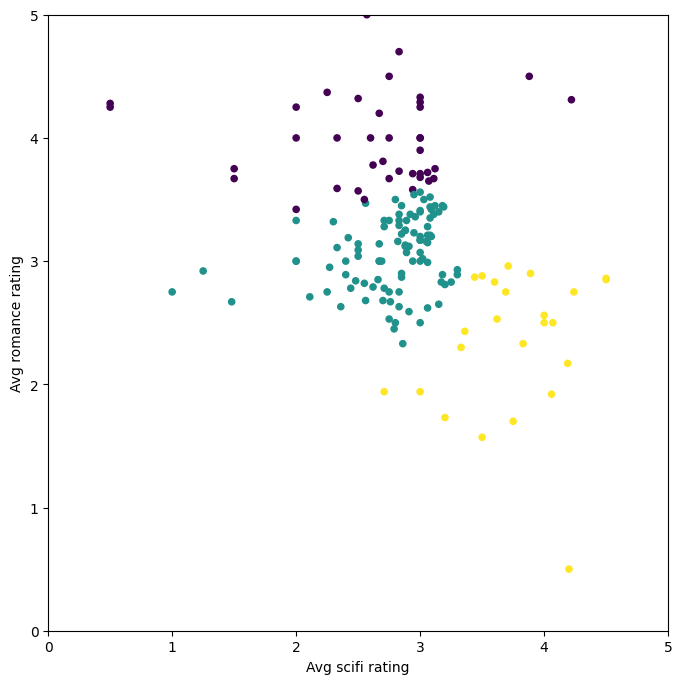

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


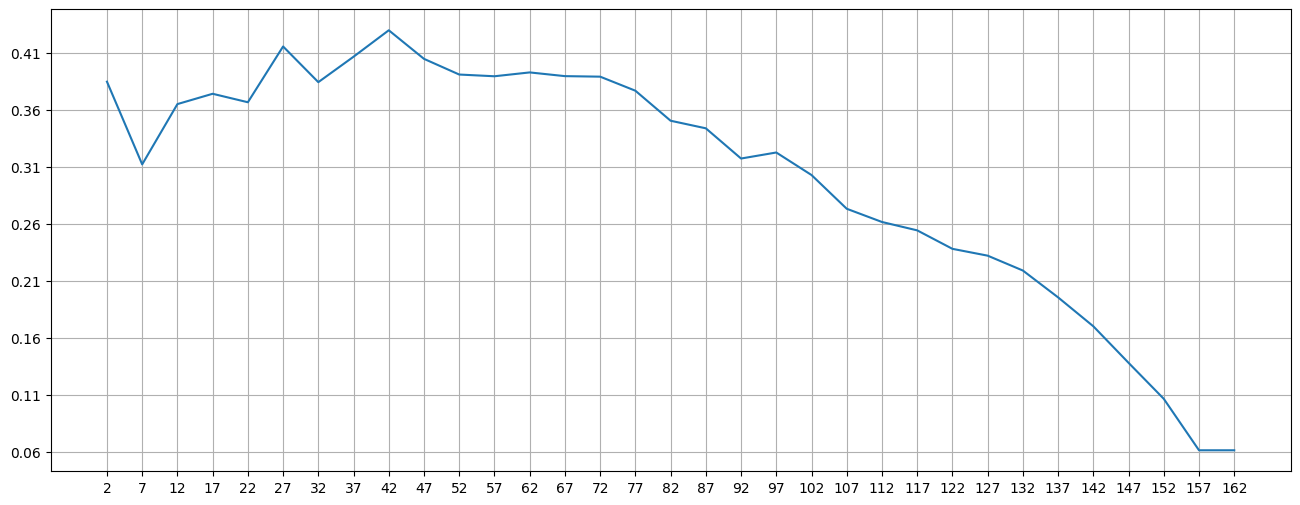

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



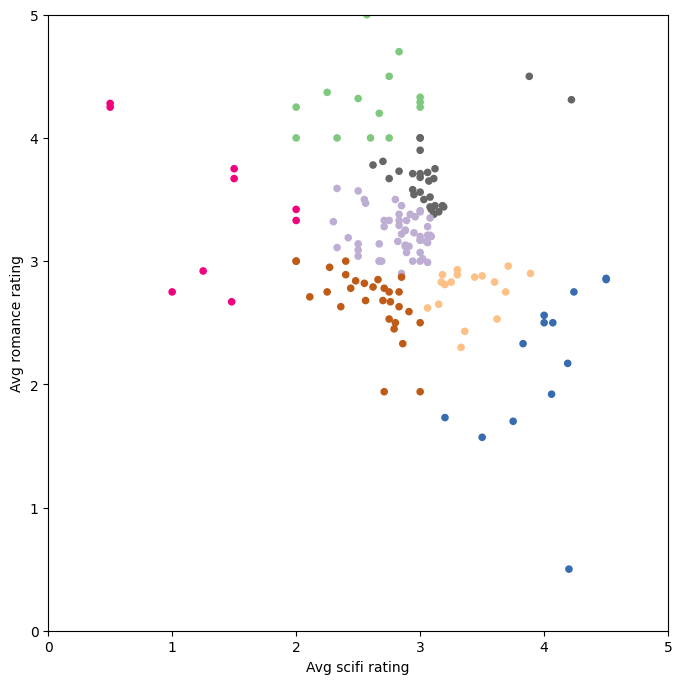

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


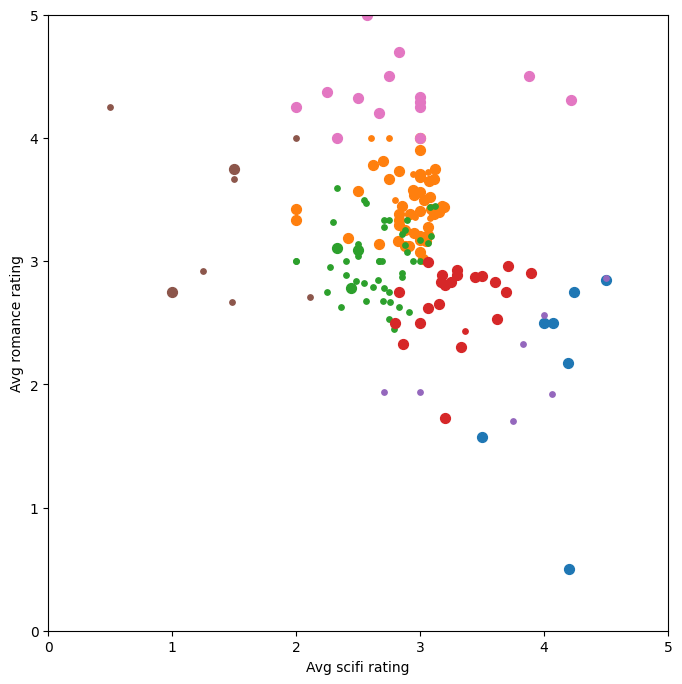

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

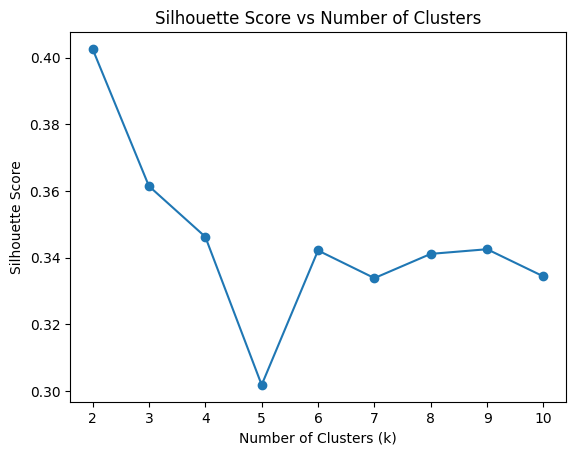

Optimal number of clusters (k): 2


In [16]:
#excercise code
from sklearn.impute import SimpleImputer

# Impute missing values with the column mean
imputer = SimpleImputer(strategy='mean')
genre_ratings_imputed = imputer.fit_transform(genre_ratings)

# Scale the data
scaled_data = scaler.fit_transform(genre_ratings_imputed)

# Run KMeans again
sil_scores = []
for k in range(2, 11):  # Trying 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    # Get silhouette score
    score = silhouette_score(scaled_data, kmeans.labels_)
    sil_scores.append(score)

# Plot silhouette scores to find the optimal k
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# The optimal k corresponds to the maximum silhouette score
optimal_k = range(2, 11)[np.argmax(sil_scores)]
print(f'Optimal number of clusters (k): {optimal_k}')


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [17]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
import pandas as pd

# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count the non-null ratings for each movie (number of ratings)
    movie_ratings_count = user_movie_ratings.notnull().sum(axis=0)

    # 2- Sort movies by the count of ratings in descending order
    sorted_movie_ratings_count = movie_ratings_count.sort_values(ascending=False)

    # 3- Get the top 'max_number_of_movies' movies
    most_rated_movies = user_movie_ratings[sorted_movie_ratings_count.index[:max_number_of_movies]]
    return most_rated_movies

# Define function to get the user who rates a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    # 1- Count the number of ratings per user (non-null ratings)
    most_rated_movies['num_ratings'] = most_rated_movies.notnull().sum(axis=1)

    # 2- Sort users by the number of ratings they made
    sorted_users = most_rated_movies['num_ratings'].sort_values(ascending=False)

    # 3- Get the top 'n_users' users who rated the most movies
    top_users = sorted_users.head(n_users).index
    most_rated_movies = most_rated_movies.loc[top_users]

    # Drop the 'num_ratings' column for the final output
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    # Get the most rated movies
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)

    # Get the users who rate the most
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)

    return most_rated_movies

# Example DataFrame: Replace this with your actual user_movie_ratings DataFrame
user_movie_ratings = pd.DataFrame({
    'movie1': [5, 4, 3, None, 2],
    'movie2': [None, 3, 4, 5, 1],
    'movie3': [4, 3, 2, 1, 5],
    'movie4': [2, None, None, 5, 4],
    'movie5': [None, 3, 4, 2, 1]
})

# Choose the number of movies and users and sort
n_movies = 3
n_users = 3
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


dataset dimensions:  (3, 3)
   movie3  movie1  movie2
1       3     4.0     3.0
4       5     2.0     1.0
2       2     3.0     4.0


<ipython-input-19-0a3ac46787e7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_rated_movies['num_ratings'] = most_rated_movies.notnull().sum(axis=1)


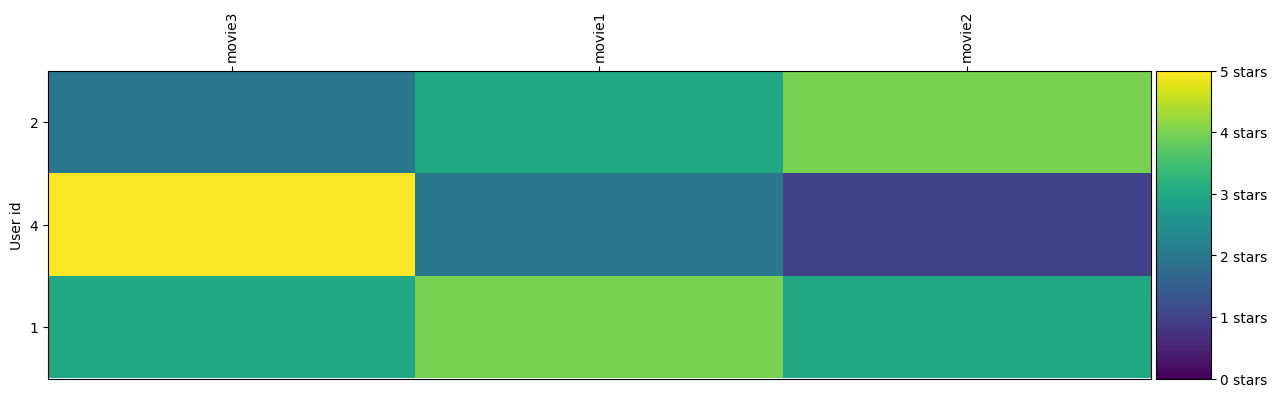

In [20]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [21]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [22]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

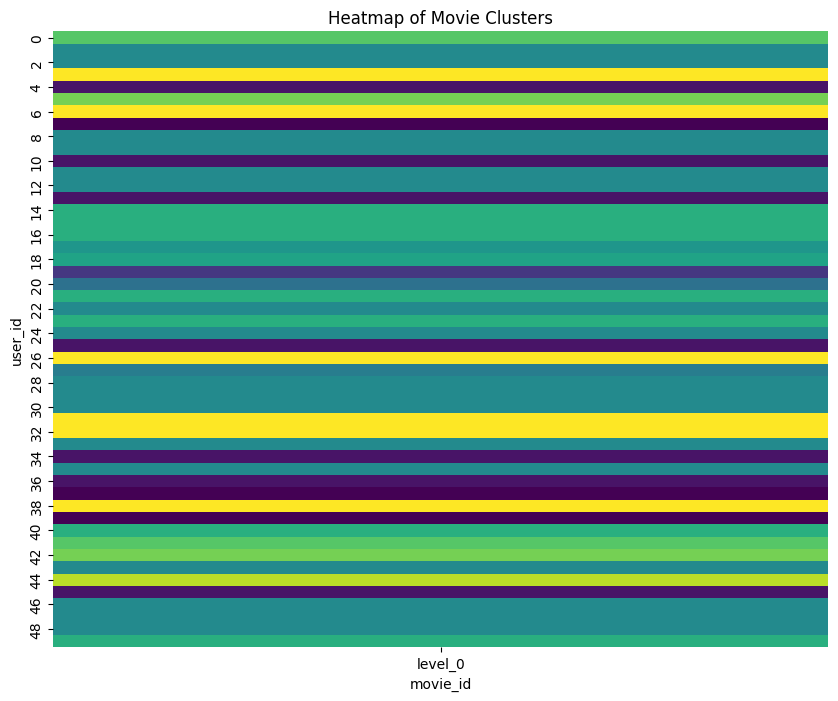

In [28]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming sparse_ratings is your original sparse ratings matrix and user_movie_ratings is the DataFrame
# If it's a sparse matrix, convert to dense format or use 'elkan' algorithm for sparse support in KMeans
dense_ratings = sparse_ratings.toarray()  # If sparse_ratings is a sparse matrix

# Fit KMeans with 20 clusters
predictions = KMeans(n_clusters=20, algorithm='elkan', random_state=42).fit_predict(dense_ratings)

# Function to get the most rated movies (for top 1000)
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    movie_ratings_count = user_movie_ratings.notnull().sum(axis=0)
    sorted_movie_ratings_count = movie_ratings_count.sort_values(ascending=False)
    most_rated_movies = user_movie_ratings[sorted_movie_ratings_count.index[:max_number_of_movies]]
    return most_rated_movies

# Ensure that user_movie_ratings has 'user_id' as a column (assuming this is a user-item matrix)
user_movie_ratings['user_id'] = user_movie_ratings.index  # Assuming index is user_id
user_movie_ratings = user_movie_ratings.reset_index()

# Create movie_id column by repeating movie names for each row (the column names are movie IDs)
user_movie_ratings = user_movie_ratings.melt(id_vars=['user_id'], var_name='movie_id', value_name='rating')

# Get the most rated movies and add the cluster predictions
most_rated_movies = get_most_rated_movies(user_movie_ratings, 1000)

# Concatenate the predictions (clusters) with the most rated movies
clustered = pd.concat([most_rated_movies, pd.DataFrame({'group': predictions})], axis=1)

# Function to draw a heatmap of movie clusters
def draw_movie_clusters(clustered, max_users, max_movies):
    # Take the first max_users and max_movies
    clustered_sample = clustered.iloc[:max_users, :max_movies]

    # Pivot the DataFrame to create a user-movie matrix
    movie_cluster_matrix = clustered_sample.pivot(index='user_id', columns='movie_id', values='group')

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(movie_cluster_matrix, cmap="viridis", annot=False, cbar=False)
    plt.title('Heatmap of Movie Clusters')
    plt.show()

# Correctly assign values to max_users and max_movies
max_users = 50  # Set a value for max_users
max_movies = 30  # Set a value for max_movies

# Call the function to draw the movie clusters (set max_users and max_movies as needed)
draw_movie_clusters(clustered, max_users, max_movies)


### Predictions and Recommendation

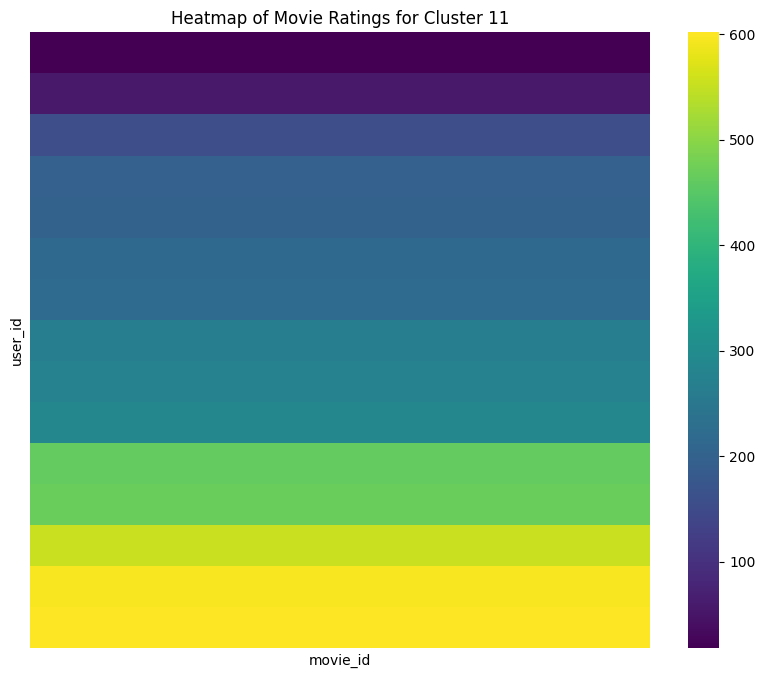

In [30]:
# Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300

# Filter the dataset by the selected cluster
cluster = clustered[clustered['group'] == cluster_number]

# Ensure 'index' and 'group' columns are present before attempting to drop them
if 'index' in cluster.columns and 'group' in cluster.columns:
    cluster = cluster.drop(['index', 'group'], axis=1)

# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)

# Function to draw a heatmap of movie ratings
def draw_movies_heatmap(cluster, axis_labels=True):
    # Create the user-movie matrix
    user_movie_matrix = cluster.pivot(index='user_id', columns='movie_id', values='rating')

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_movie_matrix, cmap="viridis", annot=False, cbar=True, xticklabels=axis_labels, yticklabels=axis_labels)
    plt.title('Heatmap of Movie Ratings for Cluster {}'.format(cluster_number))
    plt.show()

# Call the function to draw the heatmap
draw_movies_heatmap(cluster, axis_labels=False)


In [32]:
# Name of the movie
movie_name = "Matrix, The (1999)"

# Check if the movie is in the cluster DataFrame columns
if movie_name in cluster.columns:
    average_rating = cluster[movie_name].mean()
    print(f"The average rating for '{movie_name}' in cluster {cluster_number} is {average_rating:.2f}")
else:
    print(f"Movie '{movie_name}' not found in the cluster.")


Movie 'Matrix, The (1999)' not found in the cluster.


In [35]:
# Select only the numeric columns for calculating average ratings
numeric_columns = cluster.select_dtypes(include=[np.number])

# Calculate the average rating of all movies in the cluster
average_ratings = numeric_columns.mean()

# Select the top 20 movies based on average rating
top_20_movies = average_ratings.head(20)

# Print the results
print("The average ratings of the top 20 movies in the cluster are:")
print(top_20_movies)


The average ratings of the top 20 movies in the cluster are:
user_id    304.866667
rating     304.866667
group       11.000000
dtype: float64


In [36]:
cluster

,user_id,movie_id,rating,group
18,18,level_0,18.0,11.0
56,56,level_0,56.0,11.0
155,155,level_0,155.0,11.0
198,198,level_0,198.0,11.0
201,201,level_0,201.0,11.0
216,216,level_0,216.0,11.0
220,220,level_0,220.0,11.0
265,265,level_0,265.0,11.0
274,274,level_0,274.0,11.0
289,289,level_0,289.0,11.0


In [38]:
# Ensure user_id is properly indexed in the cluster DataFrame
user_id = 7

# Check if user_id is in the cluster DataFrame index
if user_id in cluster.index:
    # Get all the user's ratings from the cluster
    user_2_ratings = cluster.loc[user_id, :]

    # Which movies did the user not rate?
    user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]

    # What are the average ratings of these movies the user has not rated?
    avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').iloc[:, 1]

    # Sort the ratings so the highest rated movies are presented first
    top_20_unrated_movies = avg_ratings.sort_values(ascending=False).head(20)

    print("Top 20 unrated movies for user", user_id)
    print(top_20_unrated_movies)
else:
    print(f"User ID {user_id} not found in the cluster.")


User ID 7 not found in the cluster.


## Using Collaborative Filtering (With fast.ai)

In [39]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00


In [40]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [41]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [42]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [43]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [44]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [45]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [46]:
dls.show_batch()

,user,title,rating
0,361,"Princess Bride, The (1987)",5
1,537,Anne Frank Remembered (1995),3
2,530,Fargo (1996),4
3,523,Four Weddings and a Funeral (1994),5
4,269,Gaslight (1944),4
5,919,"Fifth Element, The (1997)",3
6,747,Mars Attacks! (1996),5
7,145,"Time to Kill, A (1996)",5
8,479,"Lost World: Jurassic Park, The (1997)",2
9,7,Field of Dreams (1989),4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [47]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [48]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.908075,0.958251,00:09
1,0.680641,0.899345,00:08
2,0.545666,0.873880,00:08
3,0.467708,0.861829,00:08
4,0.443494,0.858412,00:09


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [49]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [50]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [51]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [52]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3459),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3249), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3213),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3033), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2928), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2793), 'Airheads (1994)', 2.34375),
 (tensor(-0.2642), 'Ready to Wear (Pret-A-Porter) (1994)', 1.8333333333333333),
 (tensor(-0.2568), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2381), 'In the Army Now (1994)', 2.2777777777777777),
 (tensor(-0.2337), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.2316), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2303), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2258), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2212), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-

Or the ones with the best bias:

In [53]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5793), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5784), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5747), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.5258), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5054), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4995), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4994), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4902), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4847), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4838), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4817), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4634), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4612), '12 Angry Men (1957)', 4.344),
 (tensor(0.4450), 'Return of the Jedi (1983)', 4.007889546351085),
 (tensor(0.4392), 'Boot, Das (1981)', 4.203980099502488)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [54]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [55]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [56]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0826), 'Casablanca (1942)'),
 (tensor(1.0820), 'Chinatown (1974)'),
 (tensor(1.0596), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(1.0407),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9933), 'Lawrence of Arabia (1962)'),
 (tensor(0.9723), 'Godfather: Part II, The (1974)'),
 (tensor(0.9655), 'Secrets & Lies (1996)'),
 (tensor(0.9603), 'Manchurian Candidate, The (1962)'),
 (tensor(0.9538), 'Close Shave, A (1995)'),
 (tensor(0.9145), 'M (1931)')]

And the worst:

In [58]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2330), 'Leave It to Beaver (1997)'),
 (tensor(-1.1976), 'Jungle2Jungle (1997)'),
 (tensor(-1.1971), 'Home Alone 3 (1997)'),
 (tensor(-1.1531), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1390), "McHale's Navy (1997)"),
 (tensor(-1.0699), 'Speed 2: Cruise Control (1997)'),
 (tensor(-1.0597), 'Batman & Robin (1997)'),
 (tensor(-1.0320), 'Turbulence (1997)'),
 (tensor(-0.9955), 'Sliver (1993)'),
 (tensor(-0.9835), 'George of the Jungle (1997)')]

Same thing for our second dimension:

In [59]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0175), 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (tensor(0.9525), 'Trainspotting (1996)'),
 (tensor(0.9193), 'Serial Mom (1994)'),
 (tensor(0.9033), 'Very Brady Sequel, A (1996)'),
 (tensor(0.8063), 'Barb Wire (1996)'),
 (tensor(0.7806), 'Crumb (1994)'),
 (tensor(0.7488), 'Children of the Corn: The Gathering (1996)'),
 (tensor(0.7366), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7224), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7144), 'Pallbearer, The (1996)')]

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0662), 'Titanic (1997)'),
 (tensor(-1.0041), 'Braveheart (1995)'),
 (tensor(-0.9577), "It's a Wonderful Life (1946)"),
 (tensor(-0.9408), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9202), 'American President, The (1995)'),
 (tensor(-0.8787), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8520), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8367), 'Miracle on 34th Street (1994)'),
 (tensor(-0.8292), 'Independence Day (ID4) (1996)'),
 (tensor(-0.7988), 'Forrest Gump (1994)')]

And we can even plot the movies according to their scores on those dimensions:

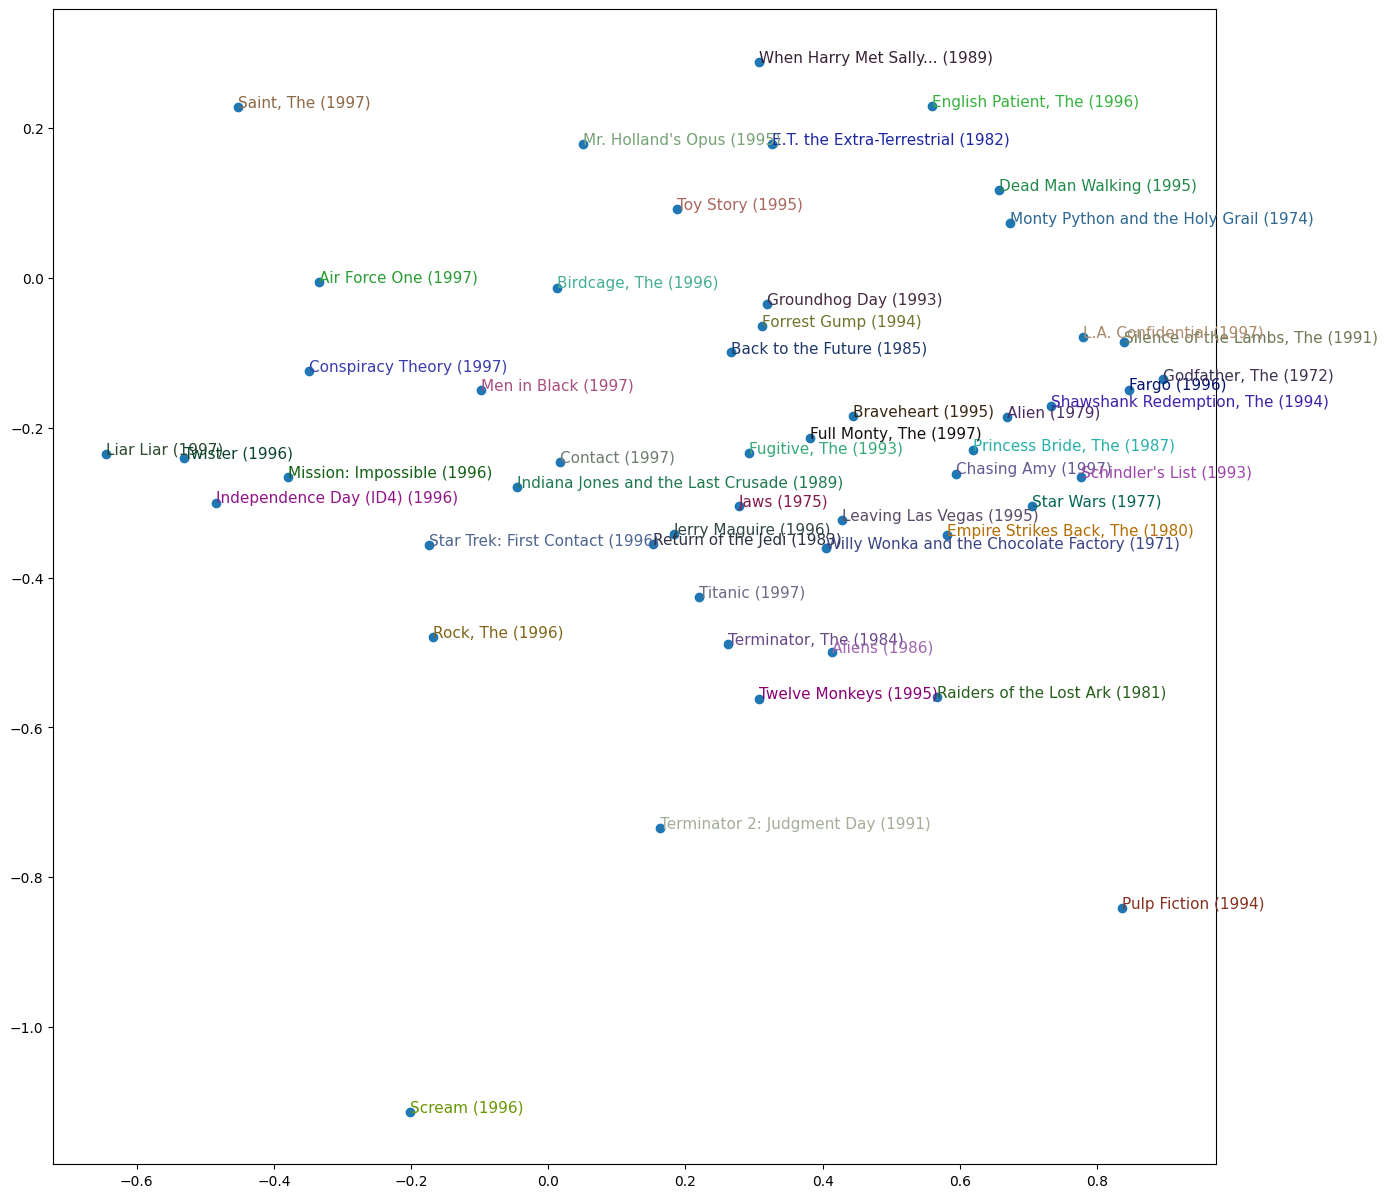

In [62]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [67]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assume that 'user_movie_ratings' is a DataFrame with columns 'user_id', 'movie_id', 'rating'

# Create a user-item matrix (pivot table) where rows are users and columns are movies
user_item_matrix = user_movie_ratings.pivot(index='user_id', columns='movie_id', values='rating')

# Fill missing values with 0 (or another strategy like mean imputation if needed)
user_item_matrix = user_item_matrix.fillna(0)

# Split the data into training and testing sets
train_data, test_data = train_test_split(user_movie_ratings, test_size=0.2, random_state=42)

# Create train and test matrices
train_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
test_matrix = test_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Apply Matrix Factorization using TruncatedSVD (an approximation to Singular Value Decomposition)
svd = TruncatedSVD(n_components=50, random_state=42)  # You can adjust n_components (number of factors)

# Fit the model to the training matrix
svd.fit(train_matrix)

# Transform both train and test data to the reduced space
train_svd = svd.transform(train_matrix)
test_svd = svd.transform(test_matrix)

# Reconstruct the matrices (predictions)
train_pred = np.dot(train_svd, svd.components_)
test_pred = np.dot(test_svd, svd.components_)

# Calculate the mean squared error for both train and test predictions
train_rmse = np.sqrt(mean_squared_error(train_matrix, train_pred))
test_rmse = np.sqrt(mean_squared_error(test_matrix, test_pred))

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Now, you can experiment with different numbers of factors (n_components), or use different ways to handle missing values


Train RMSE: 0.2895
Test RMSE: 0.2039


Identify if any such parameters have impact on the speed of convergence or the performance on the model

Yes, several parameters in collaborative filtering models (like Matrix Factorization) can significantly impact both the **speed of convergence** and **performance**. Let's go over some of them and explain their roles:

### 1. **Number of Latent Factors (`n_components`)**
   - **Impact on Speed of Convergence:**
     - **More factors**: Larger values for `n_components` lead to more complex models with more parameters to learn. This increases the training time since there are more weights to optimize.
     - **Fewer factors**: Reducing the number of components reduces the complexity of the model and can speed up convergence.
   - **Impact on Performance:**
     - **More factors**: May increase accuracy by capturing more nuanced interactions between users and items, but may lead to overfitting if the number is too high.
     - **Fewer factors**: Can lead to a simpler model with faster training but may not capture all relationships, which can reduce model performance.

### 2. **Regularization (Implicit in some models)**
   - **Impact on Speed of Convergence:**
     - **Strong regularization**: Helps prevent overfitting, potentially slowing convergence because it limits the magnitude of learned parameters. It adds constraints to the optimization process.
     - **Weak or no regularization**: Speeds up convergence but may lead to overfitting, especially with a complex dataset.
   - **Impact on Performance:**
     - **High regularization**: Prevents overfitting, but if set too high, it can underfit the model (leading to worse performance).
     - **Low regularization**: May lead to overfitting, but if set appropriately, it helps the model generalize better.

### 3. **Learning Rate (`lr_all`)**
   - **Impact on Speed of Convergence:**
     - **Higher learning rate**: Speeds up convergence initially but may lead to overshooting the optimal solution and cause instability in training.
     - **Lower learning rate**: Slower convergence, but more stable and less likely to overshoot. However, it may require more iterations (epochs) to converge.
   - **Impact on Performance:**
     - **Too high**: May cause the model to diverge, resulting in poor performance.
     - **Too low**: May result in a long training time and possibly getting stuck in local minima, causing slower or suboptimal performance.

### 4. **Number of Epochs (`n_epochs`)**
   - **Impact on Speed of Convergence:**
     - **More epochs**: More iterations over the training data allow the model to refine the parameters, leading to better performance, but takes more time to converge.
     - **Fewer epochs**: The model may not have enough time to learn the relationships between users and items, leading to quicker but less effective training.
   - **Impact on Performance:**
     - **More epochs**: Better model fit if the data is complex, but diminishing returns after a certain point.
     - **Fewer epochs**: Can lead to underfitting, meaning the model won’t capture all the interactions, which results in lower performance.

### 5. **Initialization of Factors**
   - **Impact on Speed of Convergence:**
     - **Good initialization**: A smart or heuristic-based initialization (e.g., using singular value decomposition) can speed up convergence by providing a good starting point for optimization.
     - **Random initialization**: Slower convergence due to potentially starting at poor points in the parameter space, requiring more iterations to reach optimal values.
   - **Impact on Performance:**
     - **Good initialization**: Can help achieve better results faster by starting closer to an optimal solution.
     - **Poor initialization**: Can hurt performance, especially if the algorithm gets stuck in local minima.

### 6. **Sparsity of the Dataset**
   - **Impact on Speed of Convergence:**
     - **Higher sparsity**: More missing ratings require the model to learn more from less information, which can slow down convergence, as the model needs more data to generalize well.
     - **Lower sparsity**: With more complete data, the model converges faster since it can learn from more available ratings.
   - **Impact on Performance:**
     - **High sparsity**: Can reduce performance as the model has fewer interactions to learn from.
     - **Low sparsity**: Leads to better performance because the model has more information to learn from.

### 7. **Choice of Optimization Algorithm (e.g., SGD vs. ALS)**
   - **Impact on Speed of Convergence:**
     - **SGD (Stochastic Gradient Descent)**: Slower convergence because it updates parameters more incrementally, but it can escape local minima more easily and is more flexible.
     - **ALS (Alternating Least Squares)**: Typically faster for dense matrices but may struggle with sparse datasets. It converges in fewer iterations but may not always find the global optimum.
   - **Impact on Performance:**
     - **SGD**: Often more precise and can generalize better when fine-tuned, but requires careful parameter tuning (e.g., learning rate).
     - **ALS**: Faster but may result in less optimal solutions in terms of accuracy.

### 8. **Matrix Sparsity Handling (e.g., setting missing values)**
   - **Impact on Speed of Convergence:**
     - **Different imputation strategies (e.g., filling NaNs with the mean or using advanced techniques)**: May slow down convergence, as the model learns more from assumptions or external data.
   - **Impact on Performance:**
     - **Poor imputation**: Can degrade model performance as the imputed values might not reflect true ratings.
     - **Advanced imputation**: Helps retain meaningful information for the model to learn from, resulting in better performance.

### **Summary of Impact:**
- **Convergence Speed**: Generally, **learning rate**, **number of epochs**, and **regularization** directly influence convergence speed. Choosing an appropriate number of latent factors and using a good initialization can also help speed up convergence.
- **Model Performance**: The **number of latent factors**, **regularization strength**, **learning rate**, and **epochs** directly affect performance.